In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.python import keras
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/drive/MyDrive/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(11).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(1).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(15).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(13).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(10).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(44).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(47).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(28).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(38).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(23).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(41).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(36).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(48).jpg
/content/drive/MyDrive/input/mri/Testing/pituitary_tumor/image(21).jpg
/conten

---

# Color

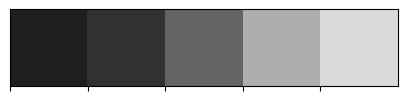

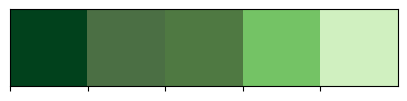

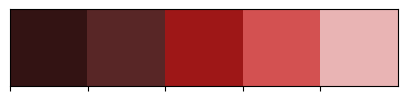

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/input/mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/input/mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:33<00:00,  2.18it/s]


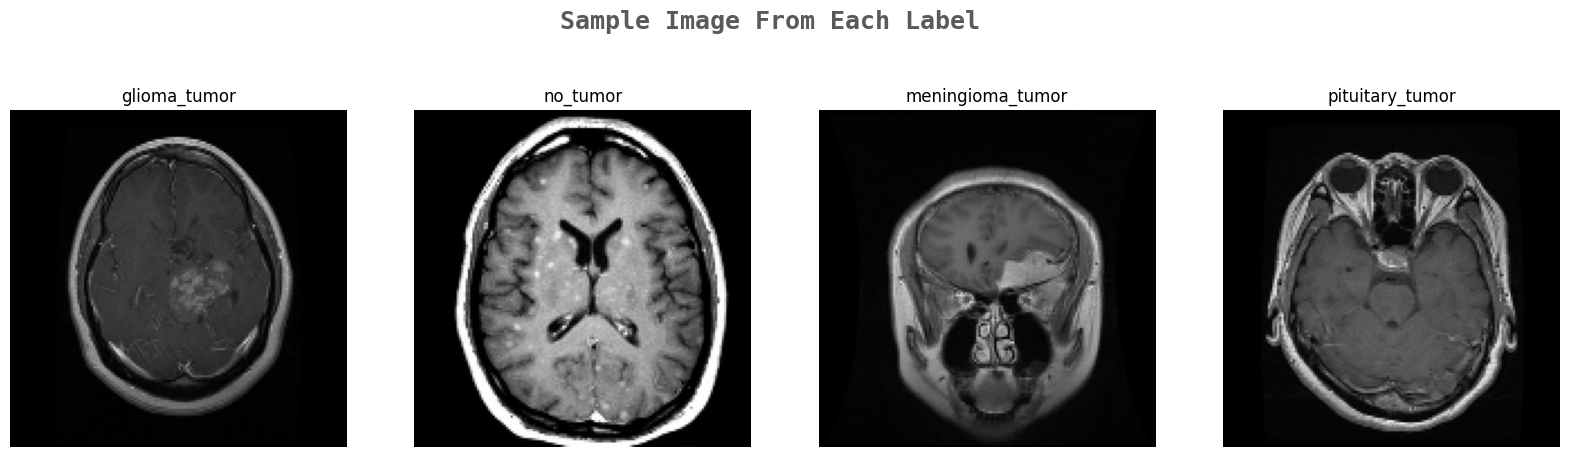

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(3274, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 150, 150, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 150, 150, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

We finally compile our model.

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.7282 - loss: 0.6758
Epoch 1: val_accuracy improved from -inf to 0.80678, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 169s 888ms/step - accuracy: 0.7292 - loss: 0.6736 - val_accuracy: 0.8068 - val_loss: 0.5956 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9239 - loss: 0.1990
Epoch 2: val_accuracy improved from 0.80678 to 0.86102, saving model to effnet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9240 - loss: 0.1988 - val_accuracy: 0.8610 - val_loss: 0.4098 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9597 - loss: 0.1174
Epoch 3: val_accuracy did not improve from 0.86102
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9597 - loss: 0.1173 - val_accuracy: 0.6678 - val_loss: 1.1866 - learning_rate: 0.0010
Epoch 4/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9730 - loss: 0.0843
Epoch 4: val_accur

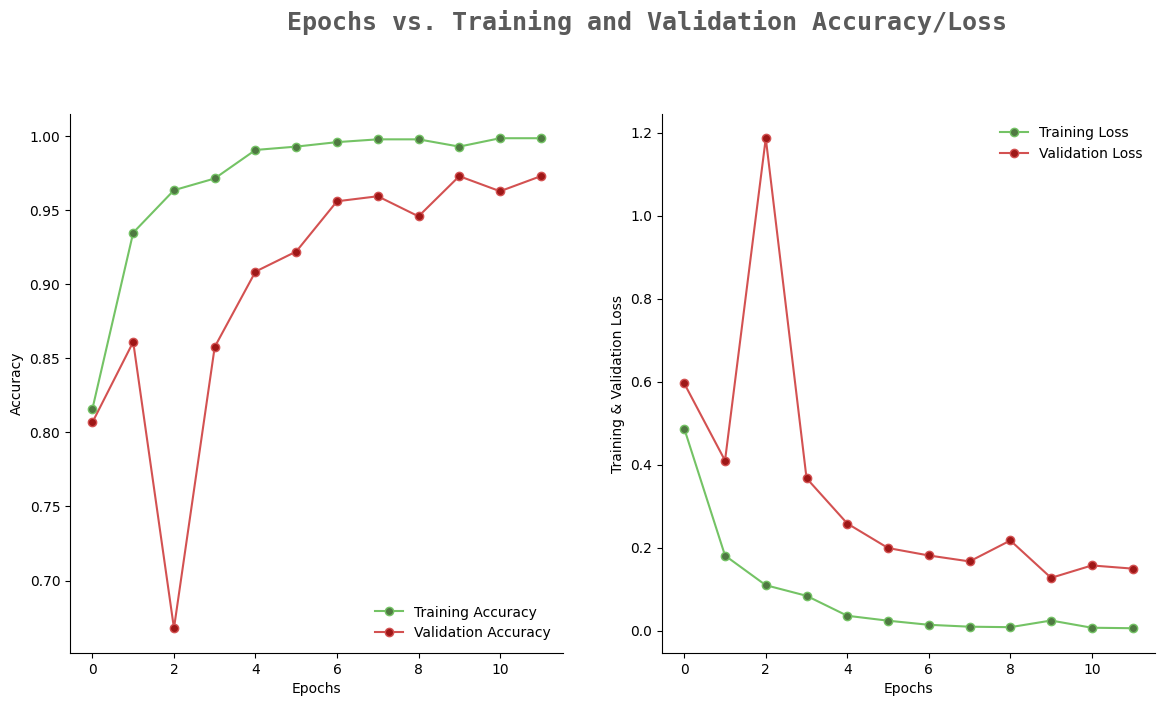

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

In [ ]:
pred = model.predict(X_test)D
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 748ms/step


---

# Evaluation



 <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        98
           1       1.00      1.00      1.00        49
           2       1.00      0.98      0.99        92
           3       0.99      1.00      0.99        89

    accuracy                           0.99       328
   macro avg       0.99      0.99      0.99       328
weighted avg       0.99      0.99      0.99       328



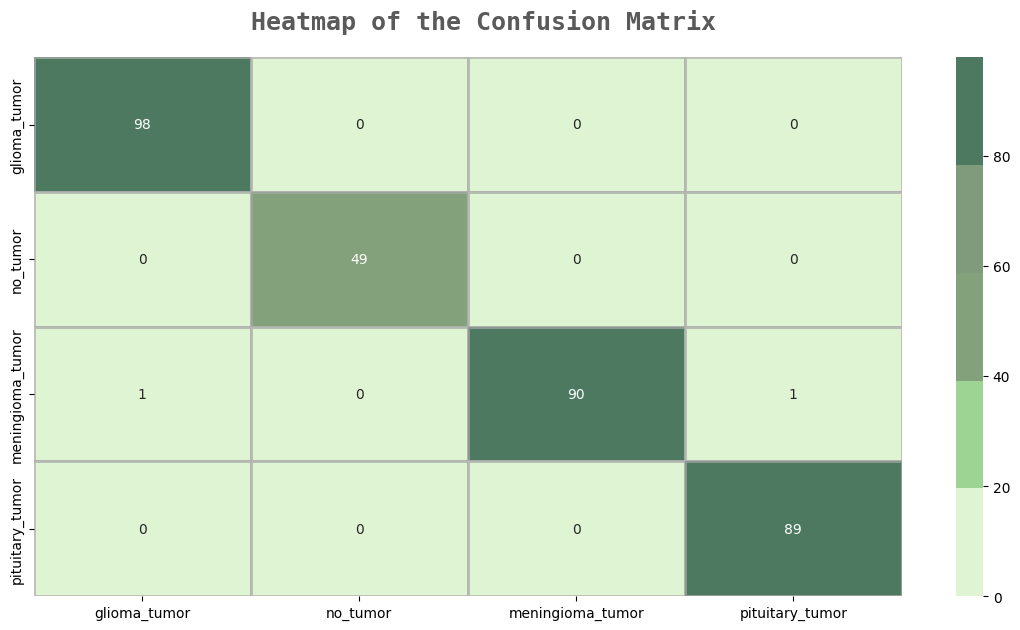

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

---

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [ ]:
model.save('brainmri.keras')

---

# Conclusion

---

In [ ]:
new_model = tf.keras.models.load_model('brain.keras')

In [ ]:
!pip install --upgrade tensorflow



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency res